In [2]:
#核心代码来自微信号gh_30599cd767ee，野生交易员的试炼之路。
#4.0版本：汇总版，加阈值。
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline #魔法命令，用于在jupyter 环境中正常显示图表
plt.rcParams['font.sans-serif']=['SimHei'] #用来在图中正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来在图中正常显示负号

datename = '180101To220825'
pricefilename = '{}{}{}'.format('data/price_',datename,'.pkl')
premfilename = '{}{}{}'.format('data/prem_',datename,'.pkl')
sizefilename = '{}{}{}'.format('data/size_',datename,'.pkl')
day_returnfilename = '{}{}{}'.format('data/day_return_',datename,'.pkl')
price100filename = '{}{}{}'.format('data/price100_',datename,'.pkl')
prem100filename = '{}{}{}'.format('data/prem100_',datename,'.pkl')
size100filename = '{}{}{}'.format('data/size100_',datename,'.pkl')
priceRankfilename = '{}{}{}'.format('data/priceRank_',datename,'.pkl')
premRankfilename = '{}{}{}'.format('data/premRank_',datename,'.pkl')
sizeRankfilename = '{}{}{}'.format('data/sizeRank_',datename,'.pkl')

pricedf=pd.read_pickle(pricefilename)  #读取收盘价矩阵
premdf=pd.read_pickle(premfilename)    #读取溢价率矩阵。
sizedf=pd.read_pickle(sizefilename)    #读取余额矩阵。
day_return=pd.read_pickle(day_returnfilename)  #读取收益率矩阵
price100df=pd.read_pickle(price100filename)  #读取收盘价百分数矩阵
prem100df=pd.read_pickle(prem100filename)    #读取溢价率百分数矩阵。
size100df=pd.read_pickle(size100filename)    #读取余额百分数矩阵。
priceRankdf=pd.read_pickle(priceRankfilename)  #读取收盘价排名矩阵
premRankdf=pd.read_pickle(premRankfilename)    #读取溢价率排名矩阵。
sizeRankdf=pd.read_pickle(sizeRankfilename)    #读取余额排名矩阵。

In [3]:
# 取小于某个分位数的所有标的, 用bool值表示
def filtTopQuantile(factor: pd.DataFrame,q=0.5) ->pd.DataFrame:
    return factor.apply(lambda x:x<=x.quantile(q) ,axis=1)

# 取排名最小的N个标的，用bool值表示
def filtTopN(factor: pd.DataFrame,N=20)->pd.DataFrame:    
    return factor.apply(lambda x:x.rank(method='first')<=N,axis=1)  #最好在rank函数中加参数method='first'

# 计算每日盈亏，输入信号、日收益表、调仓频率、 单向换仓成本
def calc_pnl(signal:pd.DataFrame,day_return:pd.DataFrame,freq=1, cost_k=0.001) ->pd.Series:   
    signal_freq=pd.DataFrame(index=signal.index)
    signal_freq=signal_freq.join(signal.iloc[range(0,len(signal),freq)])
    signal_freq=signal_freq.fillna(method='pad')
    gross_pnl=day_return[signal_freq].sum(axis=1)/signal_freq.sum(axis=1)
    cost=abs(signal_freq.diff()).sum(axis=1)*cost_k/signal_freq.sum(axis=1)
    return gross_pnl-cost

#每日选取factor表的前N个，并与昨日持仓逐个进行对比，如果超过阈值则进行轮动操作，如果在阈值以内的则按兵不动。
#注意，由于是按阈值轮动，你调用calc_pnl时，轮动周期应该设为1，设为其他周期会出现逻辑上的混乱。
def action_above_k(factor: pd.DataFrame,N: int,k: float):
    def calc_numpy(matrix,N,k):
        holding=[]
        signal=np.zeros_like(matrix)
        for i in range(matrix.shape[0]):
            row=matrix[i]
            _N=min(len(row)-np.isnan(row).sum(),N)
            row[holding]=row[holding] - k
            holding=row.argsort()[:_N]
            signal[i][holding]=1
        return signal
    signal=calc_numpy(factor.copy().to_numpy(),N,k)
    return pd.DataFrame(signal,index=factor.index,columns=factor.columns).astype(bool)

#分组回测函数。
def group_analysis(factor,forward_return,num=5,title=""):
    cutfactor=factor.rank(axis=1).apply(lambda x:pd.qcut(x,num,range(1,num+1)),axis=1)
    result=pd.DataFrame()
    for group in range(1,1+num):
        group_return=forward_return[cutfactor==group].sum(axis=1)/(cutfactor==group).sum(axis=1)
        result[group]=group_return
    result['base']=(forward_return[~factor.isna()]).sum(axis=1)/(~factor.isna()).sum(axis=1)
    (result+1).cumprod().plot(figsize=(12,5),grid=True,title=title);
    return result

#常见的评估指标包括：总收益率、年化收益率、最大回撤率、夏普率、卡玛率。
maxdd = lambda pnl: (1-(1+pnl).cumprod()/(1+pnl).cumprod().expanding().max()).max()
sharpe=lambda pnl:(pnl.mean() / pnl.std()) * (243**0.5)
gain_total=lambda pnl:(1+pnl).prod()-1
gain_yearly=lambda pnl:(1+pnl).prod()**(243/len(pnl))-1
calmar=lambda pnl:gain_yearly(pnl)/maxdd(pnl)

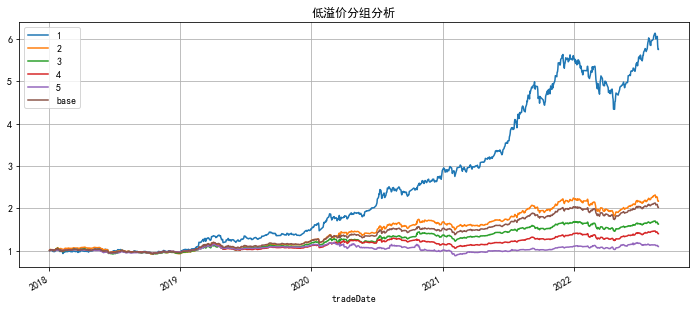

In [4]:
#对溢价率做个分组测试
group_analysis(premdf,day_return,num=5,title="低溢价分组分析");

,总收益,年化收益,夏普率,最大回撤,当年收益,当年最大回撤
低溢价阈值轮5只,19.199,0.909,2.094,0.291,0.135,0.291
低溢价阈值轮10只,8.295,0.615,1.851,0.293,0.063,0.257
低溢价阈值轮20只,5.916,0.516,1.804,0.297,0.024,0.255


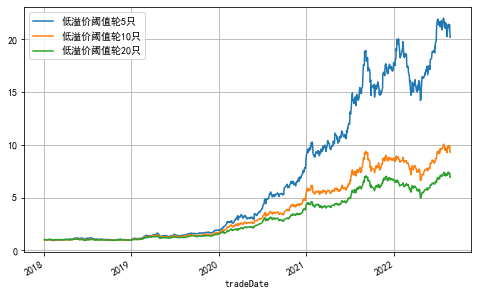

In [5]:
#低溢价加阈值轮动
df=pd.DataFrame()
for i in [5,10,20]:
    signal=action_above_k(premdf[pricedf.pct_change()<0.1],i,2)
    df[f'低溢价阈值轮{i}只']=calc_pnl(signal,day_return,1,0.001)
    
(1+df).cumprod().plot(figsize=(8,5),grid=True);  

result=pd.DataFrame()
result['总收益']=df.apply(gain_total)
result['年化收益']=df.apply(gain_yearly)
result['夏普率']=df.apply(sharpe)
result['最大回撤']=df.apply(maxdd)
result['当年收益']=df['2022'].apply(gain_total)
result['当年最大回撤']=df['2022'].apply(maxdd)
display(round(result,3))